# Showing the difference between SGD and LBFGS solvers for logistic regression

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Get the iris dataset

In [11]:
iris = load_iris()
X = iris.data   # shape (150, 4)
y = iris.target # shape (150,)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)

# Define softmax regression model

In [12]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)  # CrossEntropyLoss applies softmax internally

# Training function

In [13]:
def train_model(optimizer_name="LBFGS", max_iter=100):
    model = SoftmaxRegression(input_dim=4, output_dim=3)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "LBFGS":
        optimizer = optim.LBFGS(model.parameters(), lr=1, max_iter=20)  
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    losses = []
    
    for epoch in range(max_iter):
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            return loss

        if optimizer_name == "LBFGS":
            loss = optimizer.step(closure)
        else:
            # For SGD, we need to explicitly call forward/backward
            loss = closure()
            optimizer.step()

        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f"{optimizer_name} Epoch {epoch}: Loss = {loss.item():.4f}")

    # Evaluation
    with torch.no_grad():
        preds = torch.argmax(model(X_test), dim=1)
        acc = (preds == y_test).float().mean().item()
    print(f"{optimizer_name} Final Accuracy: {acc:.4f}\n")
    return model, losses

# Run both solvers

In [14]:
print("Training with LBFGS...")
lbfgs_model, lbfgs_losses = train_model("LBFGS", max_iter=50)

print("Training with SGD...")
sgd_model, sgd_losses = train_model("SGD", max_iter=200)


Training with LBFGS...
LBFGS Epoch 0: Loss = 1.0287
LBFGS Epoch 10: Loss = 0.0000
LBFGS Epoch 20: Loss = 0.0000
LBFGS Epoch 30: Loss = 0.0000
LBFGS Epoch 40: Loss = 0.0000
LBFGS Final Accuracy: 0.9111

Training with SGD...
SGD Epoch 0: Loss = 0.6474
SGD Epoch 10: Loss = 0.5339
SGD Epoch 20: Loss = 0.4646
SGD Epoch 30: Loss = 0.4194
SGD Epoch 40: Loss = 0.3879
SGD Epoch 50: Loss = 0.3645
SGD Epoch 60: Loss = 0.3462
SGD Epoch 70: Loss = 0.3312
SGD Epoch 80: Loss = 0.3185
SGD Epoch 90: Loss = 0.3075
SGD Epoch 100: Loss = 0.2977
SGD Epoch 110: Loss = 0.2889
SGD Epoch 120: Loss = 0.2809
SGD Epoch 130: Loss = 0.2735
SGD Epoch 140: Loss = 0.2666
SGD Epoch 150: Loss = 0.2603
SGD Epoch 160: Loss = 0.2543
SGD Epoch 170: Loss = 0.2487
SGD Epoch 180: Loss = 0.2434
SGD Epoch 190: Loss = 0.2384
SGD Final Accuracy: 0.8444



# Plot training curves side by side

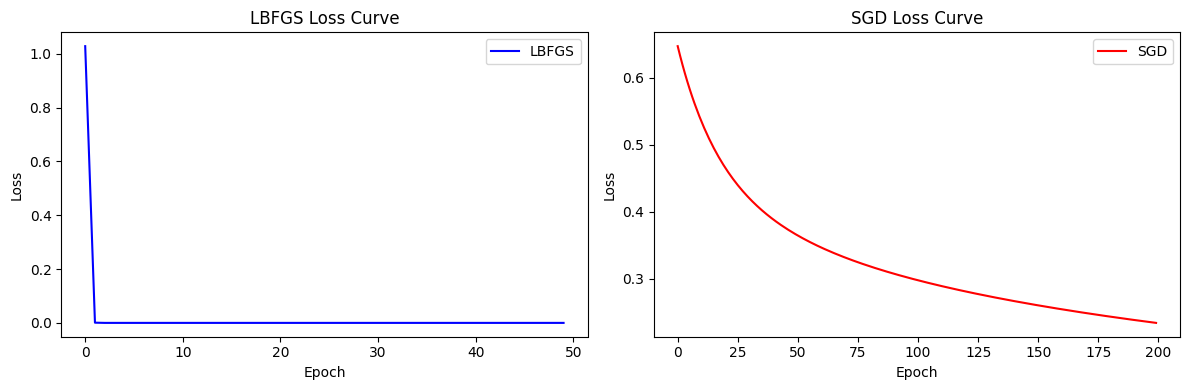

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(lbfgs_losses, label="LBFGS", color="blue")
axes[0].set_title("LBFGS Loss Curve")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(sgd_losses, label="SGD", color="red")
axes[1].set_title("SGD Loss Curve")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()